# Notebook 05: Compare Models - Phase 1 Final Results

**Mục đích:** So sánh Random Forest vs Simple CNN để quyết định Phase 2.

**Input:**
- `results/random_forest_results.json`
- `results/simple_cnn_results.json`

**Output:**
- `results/phase1_comparison.json` (comparison data)
- `results/phase1_comparison.md` (markdown report)
- `figures/phase1_comparison.png` (side-by-side visualization)

**Thời gian:** ~2 phút

---

## Decision Criteria:
- **F1-Score** là primary metric (balanced binary classification)
- Nếu CNN > RF với margin >2% → Proceed to Phase 2
- Nếu RF ≈ CNN (difference <2%) → RF đủ tốt, không cần DL phức tạp
- Xem xét thêm: Training time, Interpretability, Deployment complexity

In [1]:
# Import libraries
import sys
sys.path.append('..')

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.config import RESULTS_DIR, FIGURES_DIR
from src.evaluate import compare_models, load_results

plt.style.use('default')
%matplotlib inline

## 1. Check Available Results

In [2]:
rf_results_file = RESULTS_DIR / "random_forest_results.json"
cnn_results_file = RESULTS_DIR / "simple_cnn_results.json"

print("="*70)
print("CHECKING AVAILABLE RESULTS")
print("="*70)

rf_exists = rf_results_file.exists()
cnn_exists = cnn_results_file.exists()

print(f"\n{'✓' if rf_exists else '✗'} Random Forest results: {rf_results_file}")
print(f"{'✓' if cnn_exists else '✗'} Simple CNN results: {cnn_results_file}")

if not rf_exists:
    print("\n⚠️ Random Forest results not found. Please run notebook 03 first.")
if not cnn_exists:
    print("\n⚠️ Simple CNN results not found. Please run notebook 04 first.")

if rf_exists and cnn_exists:
    print("\n✓ Both model results available. Ready to compare!")
elif rf_exists or cnn_exists:
    print("\n⚠️ Only one model result available. Comparison will be limited.")
else:
    print("\n❌ No model results found. Cannot proceed with comparison.")

CHECKING AVAILABLE RESULTS

✓ Random Forest results: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\results\random_forest_results.json
✓ Simple CNN results: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\results\simple_cnn_results.json

✓ Both model results available. Ready to compare!


## 2. Run Comparison

In [3]:
# Run comparison
comparison = compare_models(save_report=True)

PHASE 1 MODEL COMPARISON: Random Forest vs Simple CNN

Loading results...
✓ Random Forest results loaded
✓ Simple CNN results loaded

TEST SET PERFORMANCE COMPARISON

Metric               Random Forest        Simple CNN           Winner         
---------------------------------------------------------------------------
Accuracy             0.8854               0.9688               Simple CNN     
Precision            0.8476               0.9677               Simple CNN     
Recall               0.9368               0.9677               Simple CNN     
F1                   0.8900               0.9677               Simple CNN     
Auc                  0.9440               0.9929               Simple CNN     
---------------------------------------------------------------------------
Training Time        1.29                s 70.40               s Random Forest  

OVERALL WINNER DETERMINATION

Primary Metric: F1-Score
  - Random Forest: 0.8900
  - Simple CNN:    0.9677
  - Difference:   

## 3. Detailed Metrics Comparison

In [4]:
if comparison and 'rf' in comparison and 'cnn' in comparison:
    # Create comparison dataframe
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    metrics_keys = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    
    comparison_data = []
    for metric_name, metric_key in zip(metrics_names, metrics_keys):
        rf_val = comparison['rf'][metric_key]
        cnn_val = comparison['cnn'][metric_key]
        diff = cnn_val - rf_val
        diff_pct = (diff / rf_val) * 100
        winner = 'CNN' if cnn_val > rf_val else 'RF' if rf_val > cnn_val else 'Tie'
        
        comparison_data.append({
            'Metric': metric_name,
            'Random Forest': f"{rf_val:.4f}",
            'Simple CNN': f"{cnn_val:.4f}",
            'Difference': f"{diff:+.4f}",
            'Diff %': f"{diff_pct:+.2f}%",
            'Winner': winner
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    print("\n" + "="*90)
    print("DETAILED METRICS COMPARISON (Test Set)")
    print("="*90)
    print(df_comparison.to_string(index=False))
    
    # Training time comparison
    print("\n" + "="*90)
    print("TRAINING TIME COMPARISON")
    print("="*90)
    rf_time = comparison['rf']['training_time']
    cnn_time = comparison['cnn']['training_time']
    print(f"\nRandom Forest: {rf_time:.2f}s ({rf_time/60:.2f} minutes)")
    print(f"Simple CNN:    {cnn_time:.2f}s ({cnn_time/3600:.2f} hours)")
    print(f"CNN is {cnn_time/rf_time:.1f}x slower than RF")


DETAILED METRICS COMPARISON (Test Set)
   Metric Random Forest Simple CNN Difference  Diff % Winner
 Accuracy        0.8854     0.9688    +0.0833  +9.41%    CNN
Precision        0.8476     0.9677    +0.1201 +14.17%    CNN
   Recall        0.9368     0.9677    +0.0309  +3.30%    CNN
 F1-Score        0.8900     0.9677    +0.0777  +8.74%    CNN
      AUC        0.9440     0.9929    +0.0489  +5.18%    CNN

TRAINING TIME COMPARISON

Random Forest: 1.29s (0.02 minutes)
Simple CNN:    70.40s (0.02 hours)
CNN is 54.5x slower than RF


## 4. Visualize Comparison

Phase 1 Comparison Results:



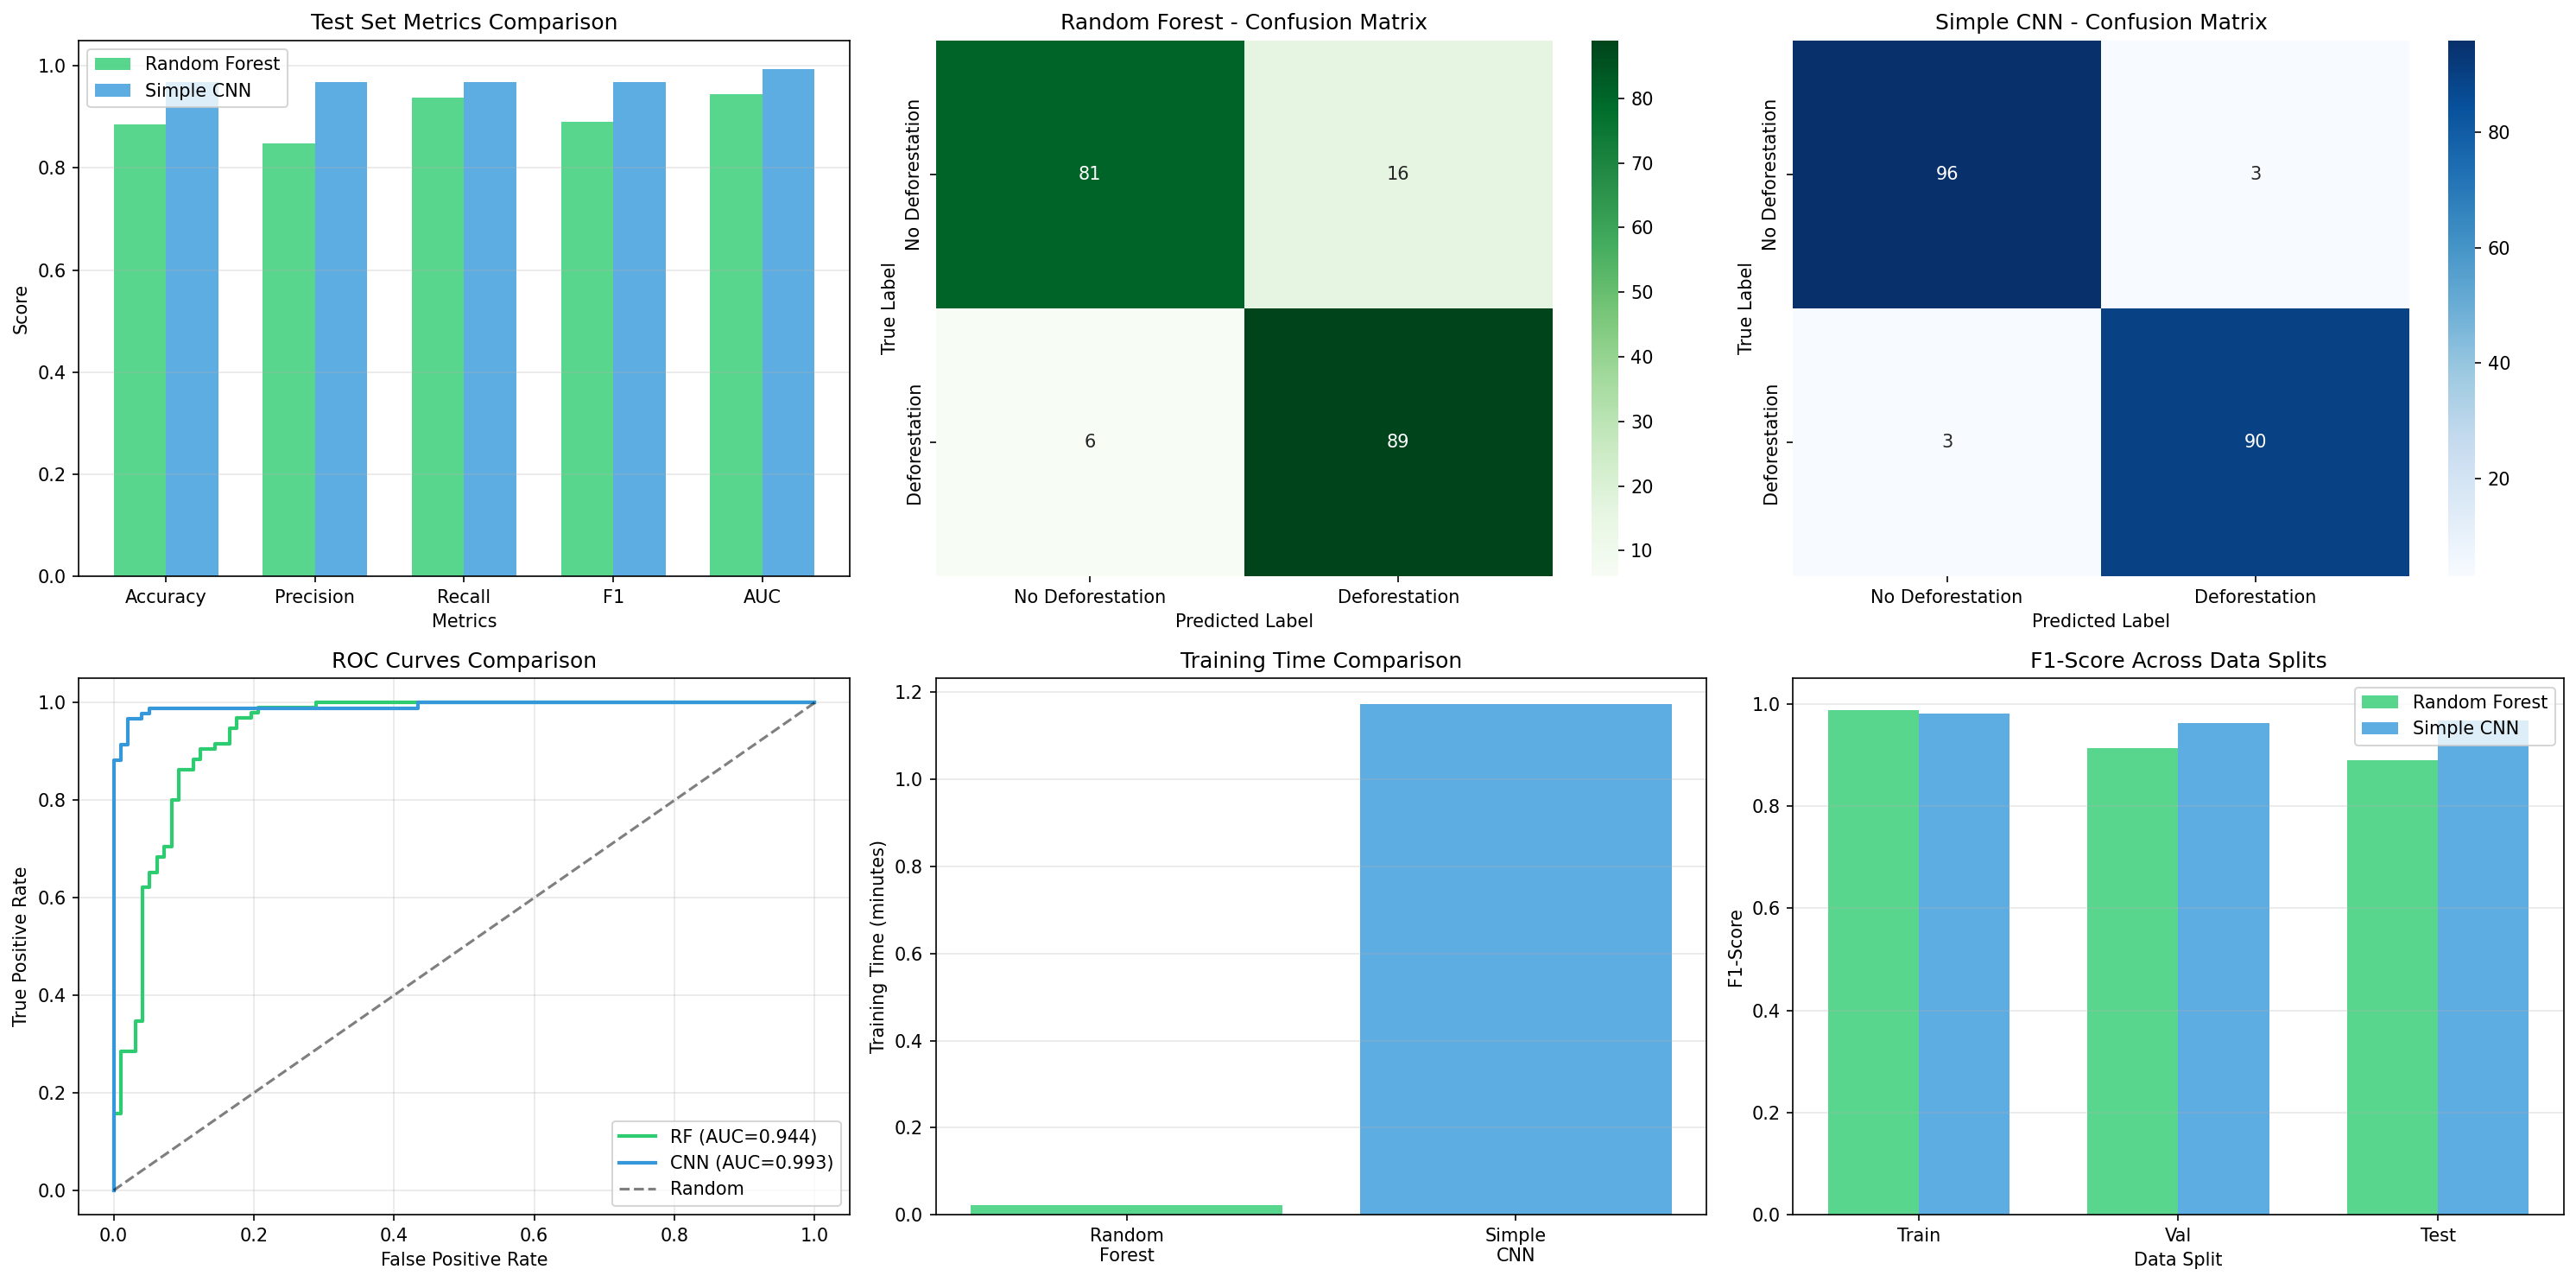

In [5]:
from IPython.display import Image, display

comparison_fig = FIGURES_DIR / "phase1_comparison.png"
if comparison_fig.exists():
    print("Phase 1 Comparison Results:\n")
    display(Image(filename=str(comparison_fig)))
else:
    print("Comparison figure not found.")

## 5. Winner Determination & Recommendations

In [6]:
if comparison and 'rf' in comparison and 'cnn' in comparison:
    rf_f1 = comparison['rf']['f1']
    cnn_f1 = comparison['cnn']['f1']
    f1_diff = abs(cnn_f1 - rf_f1)
    
    print("="*90)
    print("WINNER DETERMINATION (Based on F1-Score)")
    print("="*90)
    
    print(f"\n🎯 Primary Metric: F1-Score")
    print(f"   Random Forest: {rf_f1:.4f}")
    print(f"   Simple CNN:    {cnn_f1:.4f}")
    print(f"   Difference:    {f1_diff:.4f} ({f1_diff*100:.2f}%)")
    
    print("\n" + "="*90)
    
    if f1_diff < 0.02:  # Less than 2%
        print("🏆 RESULT: MODELS PERFORM SIMILARLY")
        print("="*90)
        print("\n📊 Analysis:")
        print(f"   F1-Score difference is only {f1_diff*100:.2f}%, which is not significant.")
        print("\n💡 Recommendation: USE RANDOM FOREST")
        print("\n   Reasons:")
        print("   ✓ Much faster training (~5-10 minutes vs 2-4 hours)")
        print("   ✓ Easier to deploy (CPU only, no GPU needed)")
        print("   ✓ More interpretable (feature importance)")
        print("   ✓ Similar performance to deep learning")
        print("\n   ⚠️ For this specific problem with 1,285 samples,")
        print("      traditional ML is sufficient. Deep learning does not")
        print("      provide significant improvement.")
        
    elif cnn_f1 > rf_f1:
        improvement_pct = ((cnn_f1 - rf_f1) / rf_f1) * 100
        print("🏆 RESULT: SIMPLE CNN WINS")
        print("="*90)
        print("\n📊 Analysis:")
        print(f"   CNN outperforms RF by {improvement_pct:.2f}%")
        print(f"   Absolute F1 improvement: {cnn_f1 - rf_f1:.4f}")
        
        if improvement_pct > 5:
            print("\n💡 Recommendation: PROCEED TO PHASE 2")
            print("\n   CNN shows significant improvement (>5%).")
            print("   Consider trying more advanced architectures:")
            print("   • Siamese Network (specialized for change detection)")
            print("   • ResNet18 (more capacity)")
            print("   • EfficientNet-B0 (state-of-art efficiency)")
            print("\n   These models may improve performance further.")
        else:
            print("\n💡 Recommendation: MARGINAL IMPROVEMENT")
            print("\n   CNN is slightly better but improvement is modest.")
            print("   Decision depends on:")
            print("   • Is 2-4 hours training time acceptable?")
            print("   • Is GPU available for deployment?")
            print("   • Is the small accuracy gain worth the complexity?")
            
    else:  # RF wins
        print("🏆 RESULT: RANDOM FOREST WINS")
        print("="*90)
        print("\n📊 Analysis:")
        print("   Random Forest surprisingly outperforms Simple CNN!")
        print("\n💡 Recommendation: USE RANDOM FOREST")
        print("\n   Traditional ML is sufficient for this task.")
        print("   Possible reasons CNN underperforms:")
        print("   • Dataset too small (899 training samples)")
        print("   • Handcrafted features capture the pattern well")
        print("   • Model overfitting despite regularization")
        
    print("\n" + "="*90)

WINNER DETERMINATION (Based on F1-Score)

🎯 Primary Metric: F1-Score
   Random Forest: 0.8900
   Simple CNN:    0.9677
   Difference:    0.0777 (7.77%)

🏆 RESULT: SIMPLE CNN WINS

📊 Analysis:
   CNN outperforms RF by 8.74%
   Absolute F1 improvement: 0.0777

💡 Recommendation: PROCEED TO PHASE 2

   CNN shows significant improvement (>5%).
   Consider trying more advanced architectures:
   • Siamese Network (specialized for change detection)
   • ResNet18 (more capacity)
   • EfficientNet-B0 (state-of-art efficiency)

   These models may improve performance further.



## 6. Export Comparison Report

In [7]:
# Read markdown report
md_report_file = RESULTS_DIR / "phase1_comparison.md"

if md_report_file.exists():
    with open(md_report_file, 'r', encoding='utf-8') as f:
        md_content = f.read()
    
    print("="*90)
    print("MARKDOWN REPORT")
    print("="*90)
    print(md_content)
    print("\n✓ Full report saved to:", md_report_file)
else:
    print("Markdown report not found.")

MARKDOWN REPORT
# Phase 1 Model Comparison Report

**Generated:** 2025-11-07 08:21:08

## Test Set Performance

| Metric | Random Forest | Simple CNN | Winner |
|--------|---------------|------------|--------|
| Accuracy | 0.8854 | 0.9688 | CNN |
| Precision | 0.8476 | 0.9677 | CNN |
| Recall | 0.9368 | 0.9677 | CNN |
| F1 | 0.8900 | 0.9677 | CNN |
| Auc | 0.9440 | 0.9929 | CNN |

## Overall Winner

**Simple CNN**

F1-Score difference: 0.0777



✓ Full report saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\results\phase1_comparison.md


## 7. Next Steps

In [8]:
print("="*90)
print("PHASE 1 COMPLETED - NEXT STEPS")
print("="*90)

if comparison and 'winner' in comparison:
    winner = comparison['winner']
    
    print(f"\n📋 Phase 1 Summary:")
    print(f"   Winner: {winner}")
    print(f"   Models trained: Random Forest + Simple CNN")
    print(f"   Dataset: 1,285 patches (899 train, 193 val, 193 test)")
    
    print("\n🚀 Possible Next Steps:")
    print("\n1. 📄 Write thesis/report with Phase 1 results")
    print("   - Include comparison table and visualizations")
    print("   - Discuss trade-offs (accuracy vs complexity vs time)")
    
    if 'CNN' in winner:
        print("\n2. 🔬 Phase 2: Advanced Deep Learning (if CNN won significantly)")
        print("   - Siamese Network for change detection")
        print("   - ResNet18 for higher capacity")
        print("   - Data augmentation to combat overfitting")
        print("   - Ensemble methods")
    
    print("\n3. 🗺️ Full-area Inference")
    print("   - Apply best model to entire Cà Mau forest")
    print("   - Generate deforestation map")
    print("   - Calculate deforestation area statistics")
    
    print("\n4. 📊 Validation with independent data")
    print("   - Collect additional ground truth points")
    print("   - Validate model on unseen areas")
    
    print("\n5. 🚀 Deployment")
    print("   - Create web interface for predictions")
    print("   - Setup automated monitoring pipeline")
    print("   - Integrate with GIS systems")

print("\n" + "="*90)
print("✓ Phase 1 Analysis Complete!")
print("="*90)

PHASE 1 COMPLETED - NEXT STEPS

📋 Phase 1 Summary:
   Winner: Simple CNN
   Models trained: Random Forest + Simple CNN
   Dataset: 1,285 patches (899 train, 193 val, 193 test)

🚀 Possible Next Steps:

1. 📄 Write thesis/report with Phase 1 results
   - Include comparison table and visualizations
   - Discuss trade-offs (accuracy vs complexity vs time)

2. 🔬 Phase 2: Advanced Deep Learning (if CNN won significantly)
   - Siamese Network for change detection
   - ResNet18 for higher capacity
   - Data augmentation to combat overfitting
   - Ensemble methods

3. 🗺️ Full-area Inference
   - Apply best model to entire Cà Mau forest
   - Generate deforestation map
   - Calculate deforestation area statistics

4. 📊 Validation with independent data
   - Collect additional ground truth points
   - Validate model on unseen areas

5. 🚀 Deployment
   - Create web interface for predictions
   - Setup automated monitoring pipeline
   - Integrate with GIS systems

✓ Phase 1 Analysis Complete!


## 8. Final Summary

In [9]:
print("\n\n")
print("#" * 90)
print("#" + " " * 88 + "#")
print("#" + " " * 20 + "PHASE 1 BASELINE MODELS - FINAL SUMMARY" + " " * 27 + "#")
print("#" + " " * 88 + "#")
print("#" * 90)

if comparison and 'rf' in comparison and 'cnn' in comparison:
    print("\n📊 Models Evaluated:")
    print("   1. Random Forest (Traditional ML)")
    print("   2. Simple CNN (Deep Learning)")
    
    print("\n📈 Best Test F1-Scores:")
    print(f"   Random Forest: {comparison['rf']['f1']:.4f}")
    print(f"   Simple CNN:    {comparison['cnn']['f1']:.4f}")
    
    print("\n🏆 Winner:", comparison.get('winner', 'N/A'))
    
    print("\n📁 All Results Saved To:")
    print("   • models/random_forest_baseline.pkl")
    print("   • models/simple_cnn_best.pth")
    print("   • results/phase1_comparison.json")
    print("   • results/phase1_comparison.md")
    print("   • figures/phase1_comparison.png")
    
    print("\n✅ Phase 1 Successfully Completed!")
    print("\n💡 Review the comparison report and decide on next steps.")

print("\n" + "#" * 90)
print()




##########################################################################################
#                                                                                        #
#                    PHASE 1 BASELINE MODELS - FINAL SUMMARY                           #
#                                                                                        #
##########################################################################################

📊 Models Evaluated:
   1. Random Forest (Traditional ML)
   2. Simple CNN (Deep Learning)

📈 Best Test F1-Scores:
   Random Forest: 0.8900
   Simple CNN:    0.9677

🏆 Winner: Simple CNN

📁 All Results Saved To:
   • models/random_forest_baseline.pkl
   • models/simple_cnn_best.pth
   • results/phase1_comparison.json
   • results/phase1_comparison.md
   • figures/phase1_comparison.png

✅ Phase 1 Successfully Completed!

💡 Review the comparison report and decide on next steps.

##############################################################